## Prediction

This notebook is used to build functions for rendering images, ROIs, and bounding boxes.

It is also used to build statistical analysis functions for making final recommendations about whether a doctor should take a tissue sample or not.

In [90]:
from importlib import reload
import libs.render as render
import libs.utils as utils
import libs.bounding_box as bbox

reload(utils)
reload(render)
reload(bbox)

<module 'libs.bounding_box' from '/home/che/Work/research/cancer_cv_project/project/libs/bounding_box.py'>

In [91]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


folder_id = '38caa6a4'
base_dir = os.path.join('./data', folder_id)
images_file = os.path.join(base_dir, 'train_images.csv')
patches_file = os.path.join(base_dir, 'train_patches.csv')
contours_dir = os.path.join(base_dir, 'contours')
images_dir = os.path.join(base_dir, 'images')

def get_image(image_name, images_dir):
    return cv2.imread(os.path.join(images_dir, image_name))
    
def get_image_df(image_id, images_file):
    df = pd.read_csv(images_file)
    return df.iloc[image_id]
    
    
def get_patches_for_image(image_uuid, patches_file):
    df = pd.read_csv(patches_file)
    patches_df = df[df['image_id'] == image_uuid]
    return patches_df

def get_contour(contour_id, contours_dir):
    df = pd.read_csv(os.path.join(contours_dir, contour_id + '.csv'))
    return df

In [92]:
# get image
img_row = get_image_df(2, images_file)
img = get_image(img_row['filename'], images_dir)

# get patches
# normally other functions will have to generate this given just an image + roi.
patches = get_patches_for_image(img_row['uuid'], patches_file)

# get contour
contour_id = patches['contour_id'].iloc[0]
roi = get_contour(contour_id, contours_dir)
roi = utils.convert_roi_dataframe_to_vector(roi)


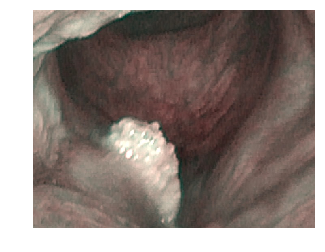

In [93]:
img2 = render.flip_channels(img)

render.plot_image(img2)

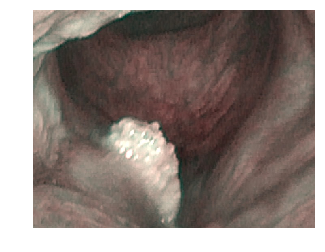

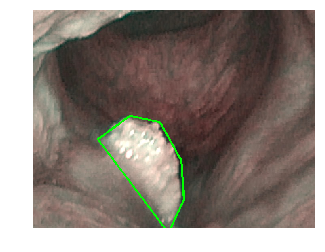

In [94]:
img_w_roi = render.draw_roi_on_image(img2.copy(), roi)

render.plot_image(img2)
render.plot_image(img_w_roi)

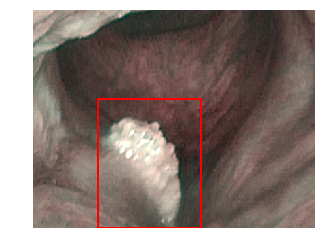

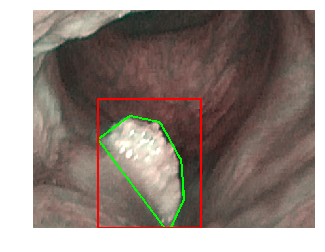

In [95]:
bb = bbox.generate_bounding_box(img2, roi)
img_w_bb = render.draw_bounding_box_on_image(img2.copy(), bb)
render.plot_image(img_w_bb)
render.plot_image_with_roi_and_bounding_box(img2.copy(), roi, bb)

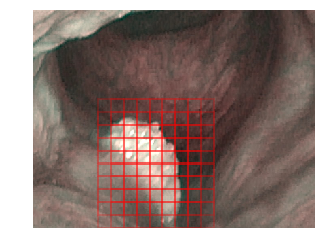

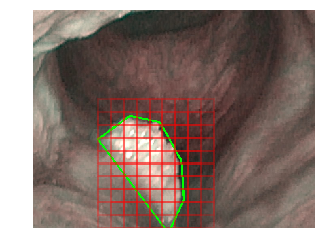

In [97]:
## Visualizing Labeled Patches
# ===========================.as_matrix()=
#  Practically, we will have the following, an array of patch images, there top left coordinates (x,y), and a label ranging from 0-2
#  where 0 = benign, 1 = papilloma, and 2 = dysplasia/carcinoma
#  
# First We'll just draw the outlines of the patches on the image, then we'll randomize some stuff and create the functions to render the overlays
# with labels and statistics, etc.

# For all the functions, all we need are the upper-left corner points of the patches and the patch_size
patch_size = 64
points = patches[['x','y']].as_matrix()
labels = np.random.choice([0,1,2], size=len(points), replace=True)
#print(labels)

reload(render)

img2 = render.flip_channels(img.copy())
render.plot_image_with_patches(img2, points)
render.plot_image_with_roi_and_patches(img2, roi, points)

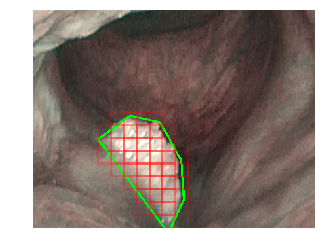

In [143]:
import libs.patch_tools as patch_tools
import libs.debug as debug
reload(patch_tools)
reload(debug)

img2 = render.flip_channels(img)

patches, points = patch_tools.generate_patches(img2, bb)
filtered_patches, filtered_points = patch_tools.filter_patches(patches, roi, points, threshold=0.6)
render.plot_image_with_roi_and_patches(img2, roi, filtered_points)

In [161]:
import libs.stats as stats
reload(stats)

cov_stats = stats.get_label_coverage_for_roi(labels)
print('{}'.format(cov_stats))
print('{}'.format(stats.should_take_tissue_sample(cov_stats)))

[0.40277778 0.34722222 0.25      ]
False
